In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
from ultralytics import YOLO
from pathlib import Path
import sys, os, cv2
import numpy as np

ROOT = Path().resolve()
SRC_DIR = ROOT / "src"

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))


from utils_LF import yolo_late_fusion, draw_fused_boxes, evaluate_yolo_predictions, confusion_matrix_yolo, plot_confusion_matrix,plot_ap_bar



In [57]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["ULTRALYTICS_IGNORE_MULTIPROCESS"] = "1"

In [58]:

model_rgb = YOLO("runs/detect/wildlife_rgb_v8n_cpu5/weights/best.pt")
model_t   = YOLO("runs/detect/wildlife_t_v8n_cpu/weights/best.pt")

print("Modelos cargados:")
print("  RGB -> runs/detect/wildlife_rgb_v8n_cpu/weights/best.pt")
print("  T   -> runs/detect/wildlife_t_from_rgb_v8n_cpu/weights/best.pt")

VAL_RGB_DIR = "data/format_rgb/images/val"
VAL_T_DIR   = "data/format_t/images/val"

OUT_DIR = "runs/late_fusion/val"
os.makedirs(OUT_DIR, exist_ok=True)

print("Directorio de salida:", OUT_DIR)

Modelos cargados:
  RGB -> runs/detect/wildlife_rgb_v8n_cpu/weights/best.pt
  T   -> runs/detect/wildlife_t_from_rgb_v8n_cpu/weights/best.pt
Directorio de salida: runs/late_fusion/val


In [59]:
class_names = {
    0: "Cow",
    1: "Deer",
    2: "Horse",

}

class_names


{0: 'Cow', 1: 'Deer', 2: 'Horse'}

In [60]:
ROOT = Path().resolve()
SRC_DIR = ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

  

model_rgb = YOLO("runs/detect/wildlife_rgb_v8n_cpu5/weights/best.pt")
model_t   = YOLO("runs/detect/wildlife_t_v8n_cpu/weights/best.pt")

VAL_RGB_DIR = "data/format_rgb/images/val"
VAL_T_DIR   = "data/format_t/images/val"

PRED_LF_DIR = "runs/late_fusion/preds"
os.makedirs(PRED_LF_DIR, exist_ok=True)

val_rgb_path = Path(VAL_RGB_DIR)
img_paths_rgb = sorted(
    list(val_rgb_path.glob("*.jpg")) +
    list(val_rgb_path.glob("*.JPG")) +
    list(val_rgb_path.glob("*.png")) +
    list(val_rgb_path.glob("*.PNG"))
)

print(f"Encontradas {len(img_paths_rgb)} imágenes RGB en {VAL_RGB_DIR}.")

for img_rgb_path in img_paths_rgb:
    img_name = img_rgb_path.name
    stem_rgb = img_rgb_path.stem  
    ext_rgb  = img_rgb_path.suffix  

    parts = stem_rgb.split("_")
    num_str = parts[-1]
    if not num_str.isdigit():
        print(f"[WARN] No puedo parsear número en {img_name}, se saltea.")
        continue

    num_rgb = int(num_str)
    num_t   = num_rgb - 1
    num_t_str = str(num_t).zfill(len(num_str))
    prefix = "_".join(parts[:-1])
    stem_t = f"{prefix}_{num_t_str}_R"

    img_t_path = Path(VAL_T_DIR) / f"{stem_t}{ext_rgb}"
    if not img_t_path.exists():

        candidates = list(Path(VAL_T_DIR).glob(f"{stem_t}.*"))
        if len(candidates) == 0:
            print(f"[WARN] No se encontró térmica para {img_name} (esperaba {stem_t}{ext_rgb})")
            continue
        img_t_path = candidates[0]

    res_rgb = model_rgb(str(img_rgb_path), imgsz=640, device="cpu", verbose=False)[0]
    res_t   = model_t(str(img_t_path),   imgsz=640, device="cpu", verbose=False)[0]

    fused = yolo_late_fusion(
        res_rgb,
        res_t,
        iou_det=0.6,
        prob_thr=0.45,
        iou_match=0.3
    )

    pred_file = Path(PRED_LF_DIR) / f"{stem_rgb}.txt"
    if fused.numel() == 0:
        open(pred_file, "w").close()
        print(f"[OK] Sin detecciones fusionadas para {img_name}")
        continue

    img_bgr = cv2.imread(str(img_rgb_path))
    H, W = img_bgr.shape[:2]

    fused_np = fused.cpu().numpy()
    with open(pred_file, "w") as f:
        for x1, y1, x2, y2, conf, cls in fused_np:
            cx = (x1 + x2) / 2.0
            cy = (y1 + y2) / 2.0
            w  = (x2 - x1)
            h  = (y2 - y1)

            cx /= W
            cy /= H
            w  /= W
            h  /= H

            line = f"{int(cls)} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f} {conf:.4f}\n"
            f.write(line)

    print(f"[OK] Predicciones Late Fusion guardadas en: {pred_file}")

print("✅ Listo: predicciones Late Fusion guardadas en:", PRED_LF_DIR)


Encontradas 64 imágenes RGB en data/format_rgb/images/val.
[OK] Predicciones Late Fusion guardadas en: runs\late_fusion\preds\020221_deer_pens_xt2_DJI_0048.txt
[OK] Predicciones Late Fusion guardadas en: runs\late_fusion\preds\020221_deer_pens_xt2_DJI_0048.txt
[OK] Predicciones Late Fusion guardadas en: runs\late_fusion\preds\020221_deer_pens_xt2_DJI_0360.txt
[OK] Predicciones Late Fusion guardadas en: runs\late_fusion\preds\020221_deer_pens_xt2_DJI_0360.txt
[OK] Predicciones Late Fusion guardadas en: runs\late_fusion\preds\022521_DJI_0132.txt
[OK] Predicciones Late Fusion guardadas en: runs\late_fusion\preds\022521_DJI_0132.txt
[OK] Sin detecciones fusionadas para 060421_DJI_0676.JPG
[OK] Sin detecciones fusionadas para 060421_DJI_0676.JPG
[OK] Sin detecciones fusionadas para 060421_DJI_0678.JPG
[OK] Sin detecciones fusionadas para 060421_DJI_0678.JPG
[OK] Predicciones Late Fusion guardadas en: runs\late_fusion\preds\071521_DeerPens_xt2_DJI_0070.txt
[OK] Predicciones Late Fusion guard

In [61]:
NUM_CLASSES = 3
CLASS_LABELS = ["Cow", "Deer", "Horse"]
GT_VAL_DIR = "data/format_rgb/labels/val"
PRED_LF_DIR = "runs/late_fusion/preds"

metrics_lf = evaluate_yolo_predictions(
    pred_dir=PRED_LF_DIR,
    gt_dir=GT_VAL_DIR,
    num_classes=NUM_CLASSES,
    iou_threshold=0.5
)

metrics_lf


{'AP_per_class': [np.float64(0.8990006741356275),
  np.float64(0.8130434781696501),
  np.float64(0.894132652964354)],
 'mAP': 0.8687256017565438,
 'TP': np.int64(85),
 'FP': np.int64(18),
 'FN': np.int64(9),
 'Precision': np.float64(0.8252427184385899),
 'Recall': np.float64(0.9042553191393164),
 'F1': np.float64(0.8629441619288309)}

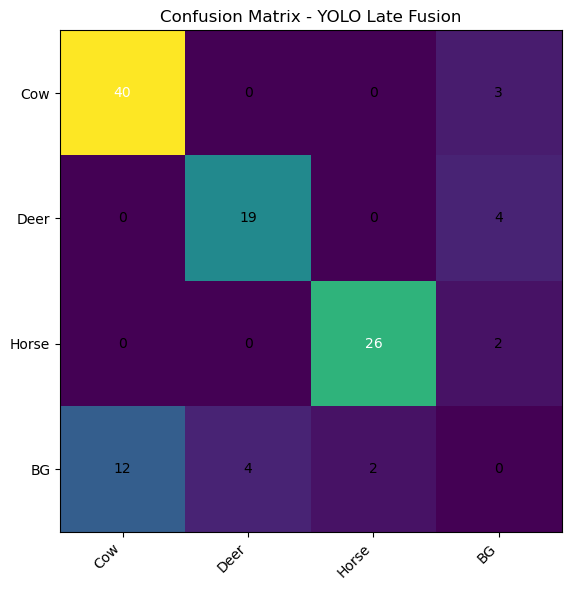

In [62]:
cm_lf = confusion_matrix_yolo(
    pred_dir=PRED_LF_DIR,
    gt_dir=GT_VAL_DIR,
    num_classes=NUM_CLASSES,
    iou_threshold=0.5
)

labels_cm = CLASS_LABELS + ["BG"]

plot_confusion_matrix(cm_lf, labels_cm, title="Confusion Matrix - YOLO Late Fusion")



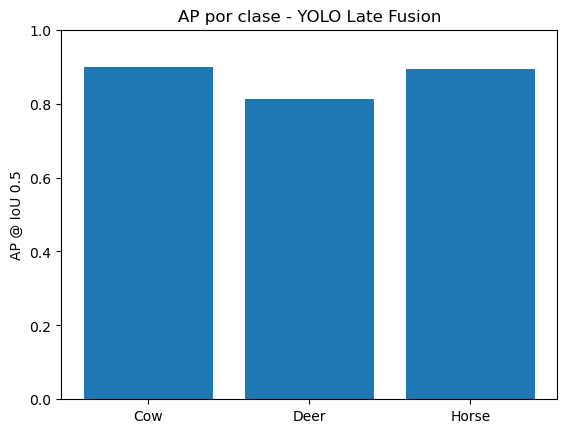

mAP@0.5: 0.8687256017565438
Precision: 0.8252427184385899
Recall: 0.9042553191393164
F1: 0.8629441619288309


In [63]:
plot_ap_bar(metrics_lf["AP_per_class"], CLASS_LABELS, title="AP por clase - YOLO Late Fusion")
print("mAP@0.5:", metrics_lf["mAP"])
print("Precision:", metrics_lf["Precision"])
print("Recall:", metrics_lf["Recall"])
print("F1:", metrics_lf["F1"])